# Project 1

### Part a: Ordinary Least Square (OLS) for the Runge function

In [49]:
# Imports

%load_ext autoreload
%autoreload 1

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [50]:
# Defining the Runge function
def f(x):
    return 1/(1+25*x**2)

In [51]:
# Defining dataset
num = 200
x = np.linspace(-1, 1, num)
y = f(x) + 0.05*np.random.normal(0, 1, num)

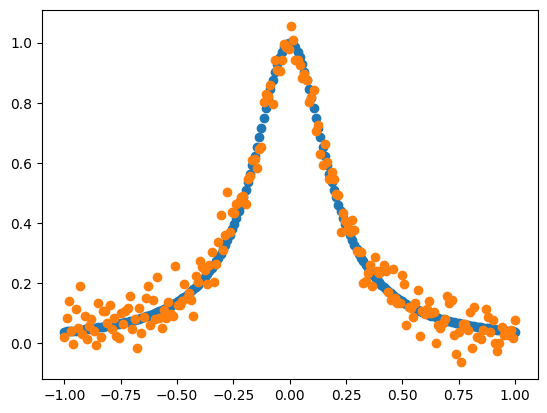

In [52]:

plt.scatter(x, f(x)) 
plt.scatter(x, y)
plt.show()

In [53]:
# Defining analytical solutions to OLS and Ridge optimal parameters

def OLS_parameters(X, y):
    X_transpose = np.transpose(X)
    return np.linalg.pinv(X_transpose @ X) @ X_transpose @ y

def Ridge_parameters(X, y, lambda_reg = 0.1):
    pred = X.shape[1]
    I = np.eye(pred) # size: (p,p)
    return np.linalg.pinv((X.T @ X)+I*lambda_reg) @ X.T @ y

In [54]:
# Defining design matrix. If intercept = False, do not include first intercept column. If intercept = True, 
# then include it. 

def polynomial_features(x, p, intercept = False):
    n = len(x)
    if intercept:
        X = np.zeros((n,p+1))
        for i in range(p+1):
            X[:, i] = x**i
    else:
        X = np.zeros((n, p))
        for i in range(1, p + 1):
            X[:, i - 1] = x ** i
    return X

In [55]:
# Functions for computing MSE and R2 scores

def MSE(y, y_pred,n = num):
    return 1/n * np.sum((y-y_pred)**2)

def R2(y, y_pred):
    return 1 - np.sum((y-y_pred)**2)/np.sum((y-np.mean(y))**2)

In [56]:
# Calculating MSE and R2 scores for different polynomial degrees. 

MAX_POLYNOMIAL_DEGREE = 20
MIN_POLYNOMIAL_DEGREE = 1

def polynomial_deg(min_degree,max_degree): 
    return np.array(range(min_degree, max_degree+1))

polynomial_degrees = polynomial_deg(MIN_POLYNOMIAL_DEGREE,MAX_POLYNOMIAL_DEGREE)

def MSE_and_R2(x,polynomial_degrees,regression_type="OLS",lamb = 0.0): 
    mse_values = np.zeros(polynomial_degrees[-1] - polynomial_degrees[0]+1)
    r2_values = np.zeros(polynomial_degrees[-1] - polynomial_degrees[0]+1)
    for p in polynomial_degrees:
        X = polynomial_features(x, p)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)
        y_offset = np.mean(y_train)
        if regression_type == "OLS": 
            theta = OLS_parameters(X_train_s, y_train - y_offset)
        else: 
            theta = Ridge_parameters(X_train_s, y_train - y_offset,lambda_reg = lamb)
        y_pred = X_test_s @ theta + y_offset
        ols_mse = MSE(y_test, y_pred)
        ols_r2 = R2(y_test, y_pred)
        mse_values[p-polynomial_degrees[0]] = ols_mse
        r2_values[p-polynomial_degrees[0]] = ols_r2
    return mse_values,r2_values
        

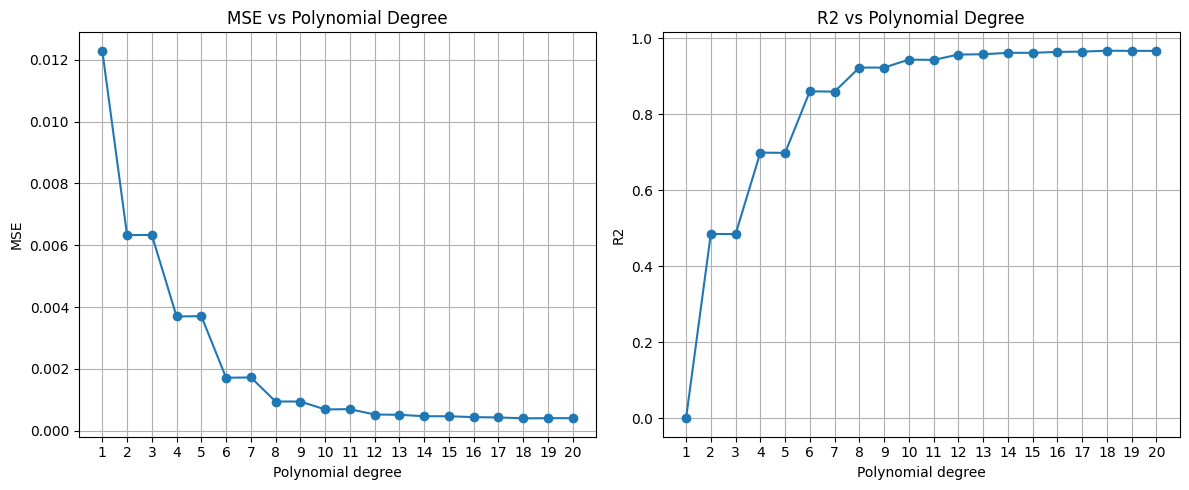

In [57]:
# Plot the MSE and R2 scores as a function of polynomial degrees

mse_values,r2_values = MSE_and_R2(x,polynomial_degrees)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(polynomial_degrees, mse_values, marker='o')
plt.title('MSE vs Polynomial Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.xticks(polynomial_degrees)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(polynomial_degrees, r2_values, marker='o')
plt.title('R2 vs Polynomial Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('R2')
plt.xticks(polynomial_degrees)
plt.grid()

plt.tight_layout()
plt.show()

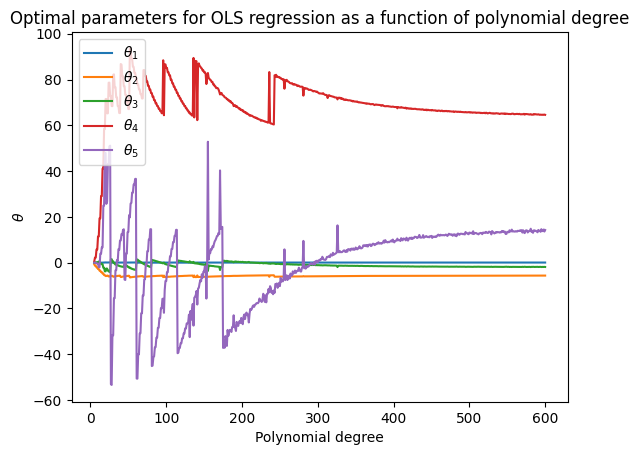

In [58]:
# Calculating and plotting optimal parameters. 

polynomial_degrees = polynomial_deg(5,600)

theta = np.zeros((len(polynomial_degrees),polynomial_degrees[0]))

def theta_val(theta,polynomial_degrees,regression_type = "OLS",lamb = 0.0): 
    for i in range(len(polynomial_degrees)):
        X = polynomial_features(x, polynomial_degrees[i])
        scaler = StandardScaler()
        scaler.fit(X)
        X_s = scaler.transform(X)
        y_offset = np.mean(y)
        if regression_type == "OLS": 
            opt_theta = OLS_parameters(X_s, y - y_offset)
        else: 
            opt_theta = Ridge_parameters(X_s, y - y_offset,lambda_reg = lamb)
        theta[i,:] = opt_theta[:theta.shape[1]]
    return theta

theta = theta_val(theta,polynomial_degrees)

for i in range(theta.shape[1]): 
    plt.plot(polynomial_degrees,theta[:,i],label=fr"$\theta_{i+1}$")

plt.xlabel("Polynomial degree")
plt.ylabel(r"$\theta$")
plt.legend()
plt.title("Optimal parameters for OLS regression as a function of polynomial degree")
plt.show()

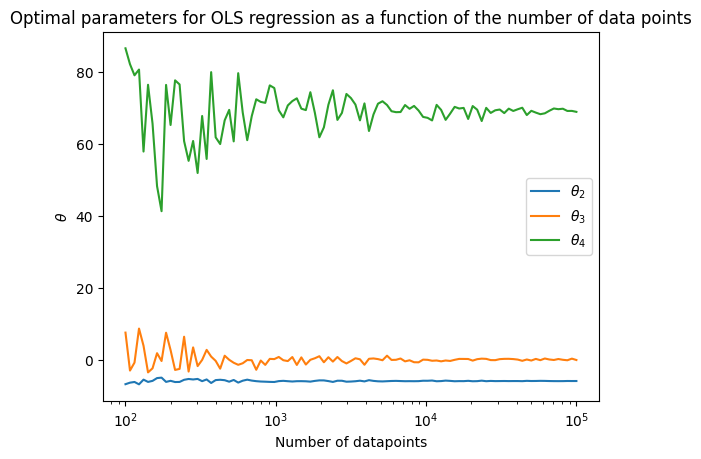

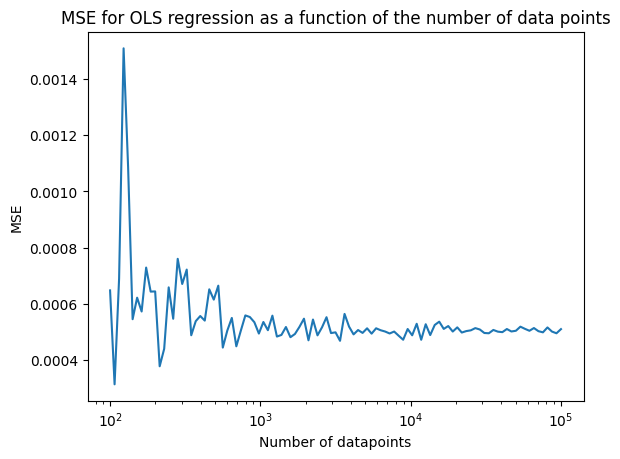

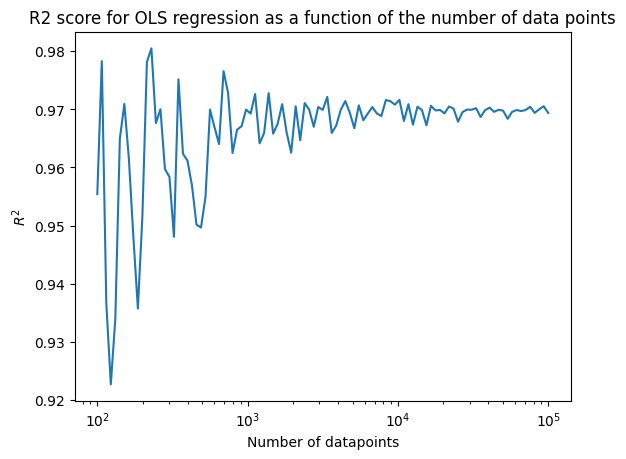

In [59]:
# Finding mse, r2 and optimal theta values as a function of the number of data points

def MSE_and_theta_val(datapoints,theta_indices,deg,regression_type = "OLS",lamb = 0.0): 
    theta_val = np.zeros((len(datapoints),len(theta_indices)))
    mse = np.zeros(len(datapoints))
    r2 = np.zeros(len(datapoints))
    for i in range(len(datapoints)):
        n = int(datapoints[i])
        x = np.linspace(-1, 1, n)
        y = f(x) + 0.05*np.random.normal(0, 1, n)
        X = polynomial_features(x, deg)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)
        y_offset = np.mean(y_train)
        if regression_type == "OLS": 
            theta = OLS_parameters(X_train_s, y_train - y_offset)
        else: 
            theta = Ridge_parameters(X_train_s, y_train - y_offset,lambda_reg = lamb)
        y_pred = X_test_s @ theta + y_offset
        mse[i] = MSE(y_test, y_pred,n)
        r2[i] = R2(y_test, y_pred)
        theta_val[i,:] = theta[theta_indices-1]
    return mse,r2,theta_val

theta_indices = np.array([2,3,4])
deg = 20
datapoints = 10**(np.linspace(2,5,101))
mse,r2,theta_val = MSE_and_theta_val(datapoints,theta_indices,deg)

for i in range(len(theta_indices)): 
    plt.semilogx(datapoints,theta_val[:,i],label=fr"$\theta_{theta_indices[i]}$")
    
plt.xlabel("Number of datapoints")
plt.ylabel(r"$\theta$")
plt.legend()
plt.title("Optimal parameters for OLS regression as a function of the number of data points")
plt.show()

plt.semilogx(datapoints,mse)
plt.xlabel("Number of datapoints")
plt.ylabel("MSE")
plt.title("MSE for OLS regression as a function of the number of data points")
plt.show()

plt.semilogx(datapoints,r2)
plt.xlabel("Number of datapoints")
plt.ylabel(r"$R^2$")
plt.title("R2 score for OLS regression as a function of the number of data points")
plt.show()

### Exercise 1b) 

We now attempt the Ridge regression model. We use different values of lambda, and plot the MSE and R2 as a function of polynomial degree. 

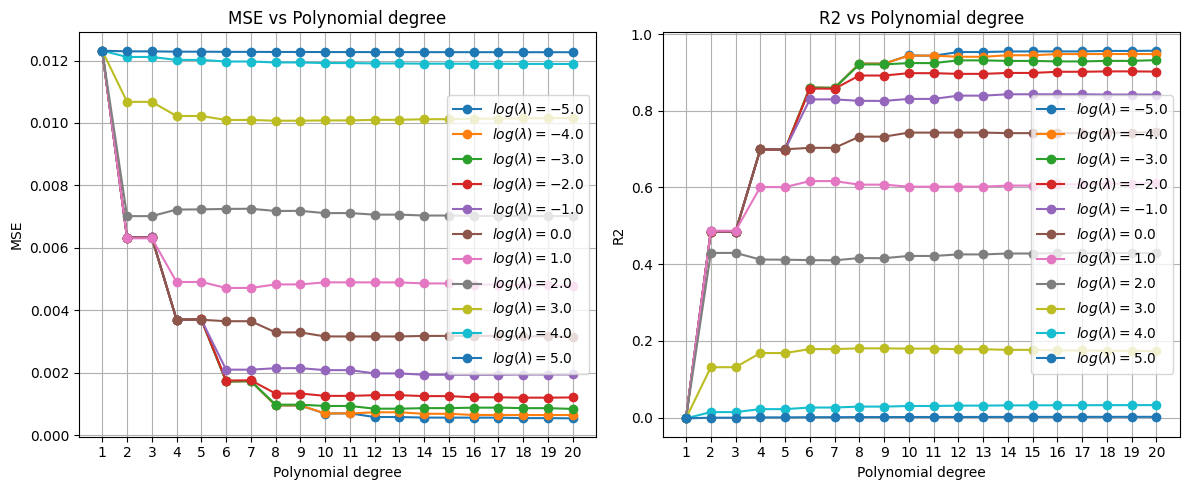

In [60]:
# Plot MSE as a function of polynomial degree, for lambda between 10^(-5) and 10^5

lamb = 10**(np.linspace(-5,5,11))

polynomial_degrees = polynomial_deg(MIN_POLYNOMIAL_DEGREE,MAX_POLYNOMIAL_DEGREE)

plt.figure(figsize=(12,5))

for i in range(len(lamb)): 
    mse_values,r2_values = MSE_and_R2(x,polynomial_degrees,regression_type="Ridge",lamb = lamb[i])
    plt.subplot(1, 2, 1)
    plt.plot(polynomial_degrees, mse_values, marker='o',label=fr"$log(\lambda) = {np.log10(lamb[i])}$")
    plt.title('MSE vs Polynomial degree')
    plt.xlabel('Polynomial degree')
    plt.ylabel('MSE')
    plt.legend()
    plt.xticks(polynomial_degrees)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(polynomial_degrees, r2_values, marker='o',label=fr"$log(\lambda) = {np.log10(lamb[i])}$")
    plt.title('R2 vs Polynomial degree')
    plt.xlabel('Polynomial degree')
    plt.ylabel('R2')
    plt.legend()
    plt.xticks(polynomial_degrees)
    plt.grid()

plt.tight_layout()
plt.show()

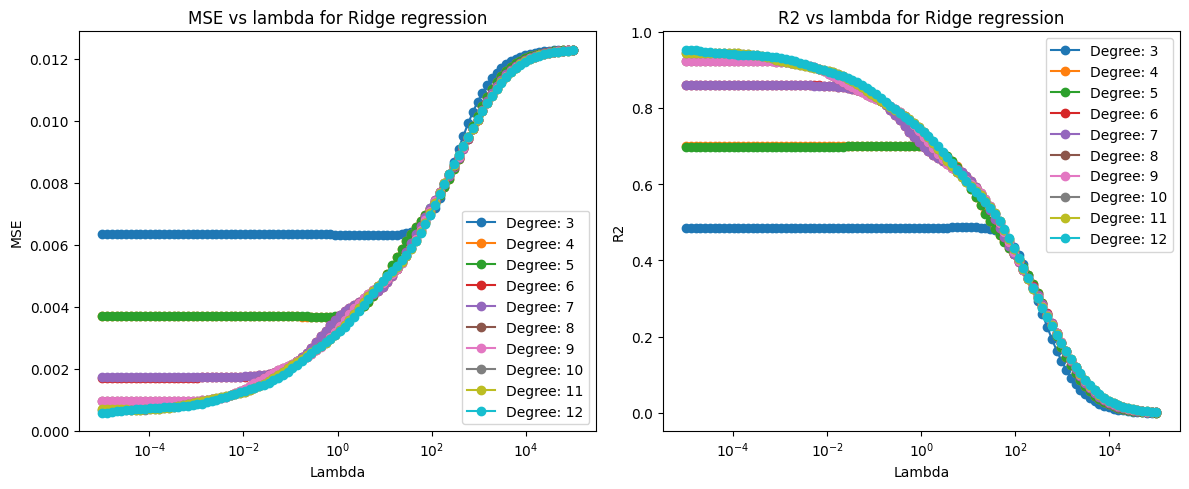

In [61]:
# Plot MSE as a function of lambda for different polynomial degrees

lamb = 10**(np.linspace(-5,5,100))

polynomial_degrees = list(range(3, 12+1))

mse = np.zeros((polynomial_degrees[-1] - polynomial_degrees[0]+1,len(lamb)))
r2 = mse.copy()

for i in range(len(lamb)): 
    mse_values,r2_values = MSE_and_R2(x,polynomial_degrees,regression_type="Ridge",lamb = lamb[i])
    mse[:,i] = mse_values
    r2[:,i] = r2_values

plt.figure(figsize=(12,5))

for j in range(len(polynomial_degrees)): 
    plt.subplot(1, 2, 1)
    plt.semilogx(lamb, mse[j,:], marker='o',label=f"Degree: {polynomial_degrees[j]}")
    plt.title('MSE vs lambda for Ridge regression')
    plt.xlabel('Lambda')
    plt.legend()
    plt.ylabel('MSE')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.semilogx(lamb, r2[j,:], marker='o',label=f"Degree: {polynomial_degrees[j]}")
    plt.title('R2 vs lambda for Ridge regression')
    plt.xlabel('Lambda')
    plt.legend()
    plt.ylabel('R2')
    plt.grid()

plt.tight_layout()
plt.show()


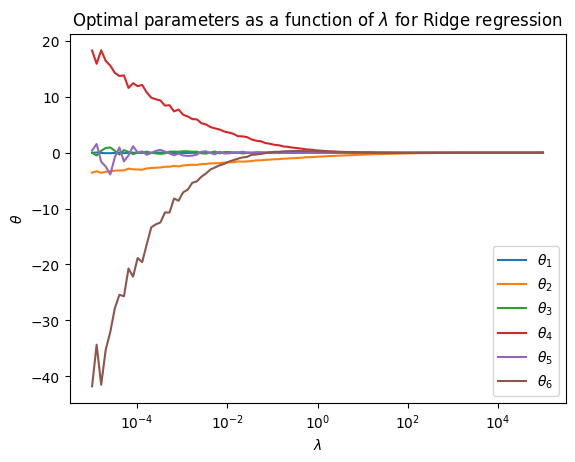

In [62]:
# Plot optimal parameters as a function of lambda

lamb = 10**(np.linspace(-5,5,100))

theta_indices = np.array([1,2,3,4,5,6])
datapoints = np.array([200])

theta = np.zeros((len(lamb),len(theta_indices)))

for i in range(len(lamb)): 
    mse,r2,theta_val = MSE_and_theta_val(datapoints,theta_indices,deg,regression_type = "Ridge",lamb = lamb[i])
    theta[i,:] = theta_val[0,:]

for j in range(len(theta_indices)): 
    plt.semilogx(lamb, theta[:,j], label=fr"$\theta_{theta_indices[j]}$")
    plt.title(r'Optimal parameters as a function of $\lambda$ for Ridge regression')
    plt.xlabel(r"$\lambda$")
    plt.legend()
    plt.ylabel(r"$\theta$")
    plt.grid()

plt.show()


In [63]:
# Values of MSE and R2 for a large number of datapoints (10^7), for different values of lambda

lamb = 10**(np.linspace(-5,5,11))

datapoints = np.array([10**7])

theta_indices = np.array([4])

for i in range(len(lamb)): 
    mse,r2,theta_val = MSE_and_theta_val(datapoints,theta_indices,deg,regression_type = "Ridge",lamb = lamb[i])
    print("MSE value for log(lambda) = " + str(np.log10(lamb[i])) + ": " + str(mse[0]))
    print("R2 value for log(lambda) = " + str(np.log10(lamb[i])) + ": " + str(r2[0]))
    print("")
    print("")



MSE value for log(lambda) = -5.0: 0.0005162883609991324
R2 value for log(lambda) = -5.0: 0.9690876423056217


MSE value for log(lambda) = -4.0: 0.0005196317475552024
R2 value for log(lambda) = -4.0: 0.968878427216877


MSE value for log(lambda) = -3.0: 0.0005408314382481102
R2 value for log(lambda) = -3.0: 0.9676063277209208


MSE value for log(lambda) = -2.0: 0.0005581028063630112
R2 value for log(lambda) = -2.0: 0.9665804054130861


MSE value for log(lambda) = -1.0: 0.0006125710893597493
R2 value for log(lambda) = -1.0: 0.9633036155353414


MSE value for log(lambda) = 0.0: 0.0006787448055811091
R2 value for log(lambda) = 0.0: 0.95934609425423


MSE value for log(lambda) = 1.0: 0.000825990976024996
R2 value for log(lambda) = 1.0: 0.9505185004422064


MSE value for log(lambda) = 2.0: 0.0010819614843290933
R2 value for log(lambda) = 2.0: 0.9351888595536746


MSE value for log(lambda) = 3.0: 0.0015079888069538083
R2 value for log(lambda) = 3.0: 0.9096516234992122


MSE value for log(lamb

### Exercise 1c) 

In [64]:
%aimport methods.training_methods, methods.step_methods, methods.regression_methods
from methods.training_methods import GradientDescent, StochasticGradientDescent
from methods.step_methods import ConstantGradientStep, MomentumGradientStep, ADAgradStep, RMSpropStep, AdamStep
from methods.regression_methods import OLS_Gradient, Ridge_Gradient

In [91]:
from sklearn.preprocessing import PolynomialFeatures

p = 6
X = PolynomialFeatures(p).fit_transform(x.reshape(-1, 1))
num_features = X.shape[1]

np.random.seed(1234)
theta = np.random.uniform(-1, 1, X.shape[1])
iterations = 20000

MSE for 10000 iterations for learning_rate =  0.01 :  0.012299064834862924
MSE for 10000 iterations for learning_rate =  0.0516 :  0.009839834170623117
MSE for 10000 iterations for learning_rate =  0.0932 :  0.009780659485883107
MSE for 10000 iterations for learning_rate =  0.1348 :  0.009777484654558927
MSE for 10000 iterations for learning_rate =  0.1764 :  0.009777301060084115
MSE for 10000 iterations for learning_rate =  0.218 :  0.009777290399223777
MSE for 10000 iterations for learning_rate =  0.2596 :  0.009777289780262568
MSE for 10000 iterations for learning_rate =  0.3013 :  0.009777289744340214
MSE for 10000 iterations for learning_rate =  0.3429 :  0.19611907421392968


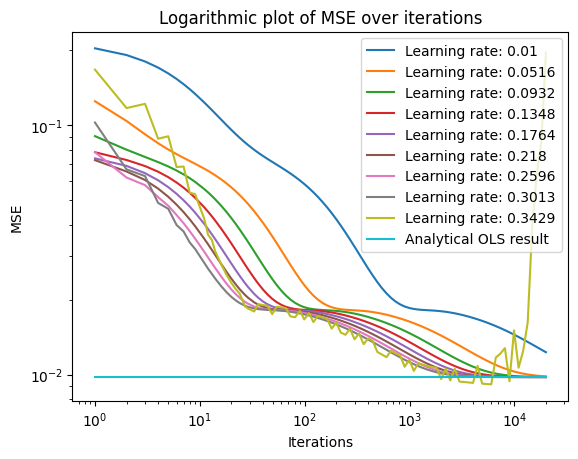

In [105]:
learning_rates = np.linspace(0.01,0.34286,9)   # 0.355 for p = 5

for i in range(len(learning_rates)): 
    gd_constant = GradientDescent(X, y, gradient=OLS_Gradient(), starting_parameters=theta, step_method=ConstantGradientStep(learning_rate=learning_rates[i]))
    mse_data_gd_constant_step = gd_constant.train(iterations=iterations, store_mse=True)
    analytical_mse = gd_constant.analytical_OLS_mse()
    print("MSE for 10000 iterations for learning_rate = ", round(learning_rates[i],4),": ",mse_data_gd_constant_step[1][len(mse_data_gd_constant_step[1]) - 1])
    plt.plot(mse_data_gd_constant_step[0], mse_data_gd_constant_step[1], label=f"Learning rate: {round(learning_rates[i],4)}")
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.loglog()
    plt.grid()
    plt.legend()

plt.plot(mse_data_gd_constant_step[0],np.ones(len(mse_data_gd_constant_step[0]))*analytical_mse,label="Analytical OLS result")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Logarithmic plot of MSE over iterations")
plt.loglog()
plt.grid()
plt.legend()

plt.title("Logarithmic plot of MSE over iterations")
plt.show()

gd_momentum = GradientDescent(X, y, gradient=OLS_Gradient(), starting_parameters=theta, step_method=MomentumGradientStep(learning_rate=0.02, momentum=0.7))
gd_ADAgrad = GradientDescent(X, y, gradient=OLS_Gradient(), starting_parameters=theta, step_method=ADAgradStep(learning_rate=0.2))
gd_RMSprop = GradientDescent(X, y, gradient=OLS_Gradient(), starting_parameters=theta, step_method=RMSpropStep(learning_rate=0.007, decay_rate=0.9))
gd_Adam = GradientDescent(X, y, gradient=OLS_Gradient(), starting_parameters=theta, step_method=AdamStep(learning_rate=0.01, beta1=0.9, beta2=0.999))


mse_data_gd_constant_step = gd_constant.train(iterations=iterations, store_mse=True)
mse_data_gd_momentum = gd_momentum.train(iterations=iterations, store_mse=True)
mse_data_gd_ADAgrad = gd_ADAgrad.train(iterations=iterations, store_mse=True)
mse_data_gd_RMSprop = gd_RMSprop.train(iterations=iterations, store_mse=True)
mse_data_gd_Adam = gd_Adam.train(iterations=iterations, store_mse=True)

MSE for 10000 iterations for learning_rate =  0.01 :  0.06088077004862872
MSE for 10000 iterations for learning_rate =  0.0162 :  0.06088077004862873
MSE for 10000 iterations for learning_rate =  0.0225 :  0.06088077004862873
MSE for 10000 iterations for learning_rate =  0.0288 :  0.06088077004862873
MSE for 10000 iterations for learning_rate =  0.035 :  0.06088077004862873
MSE for 10000 iterations for learning_rate =  0.0412 :  0.06088077004862873
MSE for 10000 iterations for learning_rate =  0.0475 :  0.06088077004862873
MSE for 10000 iterations for learning_rate =  0.0538 :  0.06088077004862873
MSE for 10000 iterations for learning_rate =  0.06 :  0.06088077004862873


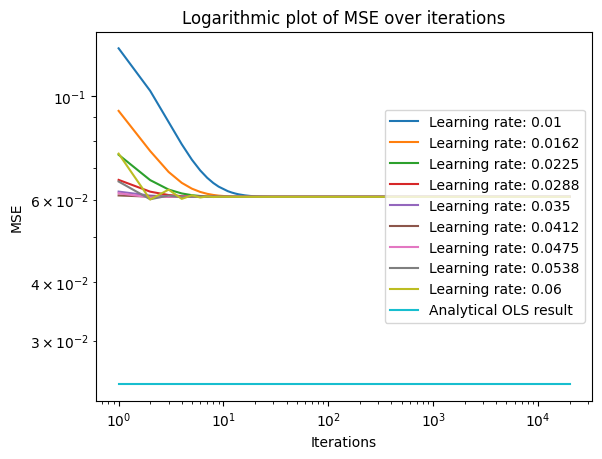

In [117]:
# Performing gradient descent for Ridge regression

learning_rates = np.linspace(0.01,0.06,9)

for i in range(len(learning_rates)): 
    gd_constant = GradientDescent(X, y, gradient=Ridge_Gradient(10**1), starting_parameters=theta, step_method=ConstantGradientStep(learning_rate=learning_rates[i]))
    mse_data_gd_constant_step = gd_constant.train(iterations=iterations, store_mse=True)
    analytical_mse = gd_constant.analytical_Ridge_mse(10**1)
    print("MSE for 10000 iterations for learning_rate = ", round(learning_rates[i],4),": ",mse_data_gd_constant_step[1][len(mse_data_gd_constant_step[1]) - 1])
    plt.plot(mse_data_gd_constant_step[0], mse_data_gd_constant_step[1], label=f"Learning rate: {round(learning_rates[i],4)}")
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.loglog()
    plt.grid()
    plt.legend(loc="right")

plt.plot(mse_data_gd_constant_step[0],np.ones(len(mse_data_gd_constant_step[0]))*analytical_mse,label="Analytical OLS result")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Logarithmic plot of MSE over iterations")
plt.loglog()
plt.grid()
plt.legend(loc="right")

plt.title("Logarithmic plot of MSE over iterations")
plt.show()